In [1]:
from __future__ import annotations

from importlib import resources
from typing import TYPE_CHECKING

import numpy as np

%matplotlib widget
from IPython.display import Math, display
from matplotlib import pyplot as plt

if TYPE_CHECKING:
    import numpy.typing as npt

# loading of the matplotlib config
with resources.as_file(resources.files("config") / "generic.mplstyle") as mplpath:
    plt.style.use(mplpath)

## $\alpha$ and $\beta$ functions

In [2]:
def _alpha_n(v_in: npt.ArrayLike) -> npt.ArrayLike:
    v_trans = 25.0
    den = 1 - np.exp(-(v_in - v_trans) / 9)
    num = 0.02 * (v_in - v_trans)
    return num / den


def _beta_n(v_in: npt.ArrayLike) -> npt.ArrayLike:
    v_trans = 25.0
    den = 1 - np.exp((v_in - v_trans) / 9)
    num = -0.002 * (v_in - v_trans)
    return num / den


def _alpha_m(v_in: npt.ArrayLike) -> npt.ArrayLike:
    v_trans = -35.0
    den = 1 - np.exp(-(v_in - v_trans) / 9)
    num = 0.182 * (v_in - v_trans)
    return num / den


def _beta_m(v_in: npt.ArrayLike) -> npt.ArrayLike:
    v_trans = -35.0
    den = 1 - np.exp((v_in - v_trans) / 9)
    num = -0.124 * (v_in - v_trans)
    return num / den


def _alpha_h(v_in: npt.ArrayLike) -> npt.ArrayLike:
    return 0.25 * np.exp(-(v_in + 90) / 12)


def _beta_h(v_in: npt.ArrayLike) -> npt.ArrayLike:
    return 0.25 * np.exp((v_in + 62) / 6 - (v_in + 90) / 12)

### Display some values of the function

This can be useful to check that your functions are implemented correctly

In [3]:
alpha_n_vex = _alpha_n(-65)
beta_n_vex = _beta_n(-65)
alpha_m_vex = _alpha_m(-65)
beta_m_vex = _beta_m(-65)
alpha_h_vex = _alpha_h(-65)
beta_h_vex = _beta_h(-65)

display(
    Math(
        r"$\alpha_n$ and $\beta_n$ for $V = -65$: "
        f"{alpha_n_vex:.3e}, {beta_n_vex:.3e}"
    )
)
display(
    Math(
        r"$\alpha_m$ and $\beta_m$ for $V = -65$: "
        f"{alpha_m_vex:.3e}, {beta_m_vex:.3e}"
    )
)
display(
    Math(
        r"$\alpha_h$ and $\beta_h$ for $V = -65$: "
        f"{alpha_h_vex:.3e}, {beta_h_vex:.3e}"
    )
)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0.5, 0, 'Voltage (mV)')

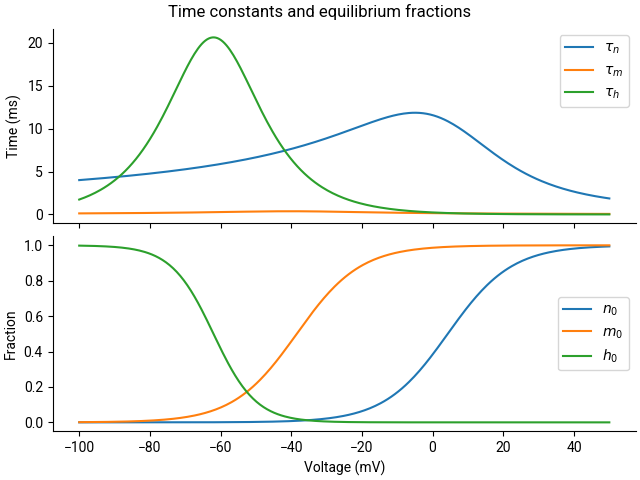

In [4]:
v_range = np.linspace(-100, 50, 300)

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle("Time constants and equilibrium fractions")
ax[0].plot(v_range, 1 / (_alpha_n(v_range) + _beta_n(v_range)), label=r"$\tau_n$")
ax[0].plot(v_range, 1 / (_alpha_m(v_range) + _beta_m(v_range)), label=r"$\tau_m$")
ax[0].plot(v_range, 1 / (_alpha_h(v_range) + _beta_h(v_range)), label=r"$\tau_h$")
ax[0].legend()
ax[0].set_ylabel("Time (ms)")
ax[1].plot(
    v_range,
    _alpha_n(v_range) / (_alpha_n(v_range) + _beta_n(v_range)),
    label=r"$n_0$",
)
ax[1].plot(
    v_range,
    _alpha_m(v_range) / (_alpha_m(v_range) + _beta_m(v_range)),
    label=r"$m_0$",
)
ax[1].plot(
    v_range,
    _alpha_h(v_range) / (_alpha_h(v_range) + _beta_h(v_range)),
    label=r"$h_0$",
)
ax[1].legend()
ax[1].set_ylabel("Fraction")
ax[1].set_xlabel("Voltage (mV)")

## Integration of the dynamical equations

We will use the Euler algorithm to integrate the equations. This is not the best method
in terms of precision, but it is enough for our purpose. We will, in any case,
introduce some noisy input later where the Euler method is close to optimal.

In [5]:
delta_t = 0.01
t_range = np.arange(0, 500, delta_t)

vout_arr = np.zeros_like(t_range)
nout_arr = np.zeros_like(t_range)
mout_arr = np.zeros_like(t_range)
hout_arr = np.zeros_like(t_range)

# other parameters
e_na = 55
e_k = -77
e_l = -65
g_na = 40
g_k = 35
g_l = 0.3
c_m = 1.0


# input current
def _current_in(time: float) -> float:
    time_step = 50.0
    if time > time_step:
        return 0.4
    return 0.0


vout = -65
nout = 0.01
hout = 0.01


def _m_eq(v_in: float) -> float:
    return _alpha_m(v_in) / (_alpha_m(v_in) + _beta_m(v_in))


def _step_hodgkin(
    v_in: float, n_in: float, h_in: float, cur_in: float
) -> tuple[float, float, float]:
    # To avoid overflow, the variables are thresholded
    frac_thr = 1e-5
    if h_in < frac_thr:
        h_in = frac_thr
    if n_in < frac_thr:
        n_in = frac_thr
    dnout = _alpha_n(v_in) * (1 - n_in) - _beta_n(v_in) * n_in
    dhout = _alpha_h(v_in) * (1 - h_in) - _beta_h(v_in) * h_in
    dvout = (
        -g_l * (v_in - e_l)
        - g_na * _m_eq(v_in) ** 3 * h_in * (v_in - e_na)
        - g_k * n_in**4 * (v_in - e_k)
        + cur_in
    ) / c_m
    return dvout, dnout, dhout


for i_ti, ti in enumerate(t_range):
    dvout, dnout, dhout = _step_hodgkin(vout, nout, hout, _current_in(ti))
    vout += delta_t * dvout
    nout += delta_t * dnout
    hout += delta_t * dhout

    vout_arr[i_ti] = vout
    nout_arr[i_ti] = nout
    mout_arr[i_ti] = _m_eq(vout)
    hout_arr[i_ti] = hout

### Plotting the dynamical variables

Text(0, 0.5, '$V_m$ (mV)')

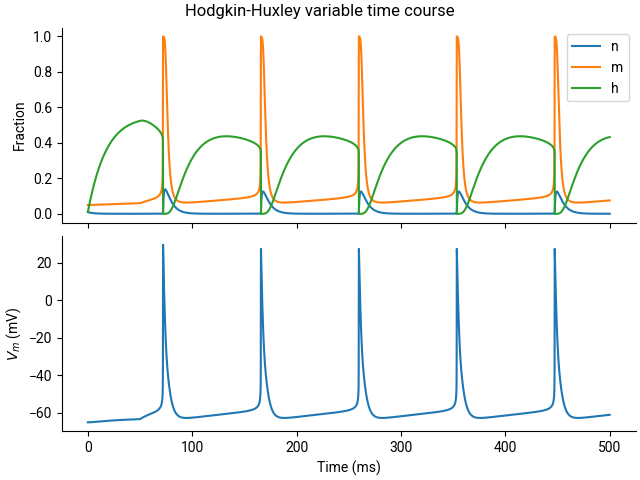

In [6]:
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle("Hodgkin-Huxley variable time course")
ax[0].plot(t_range, nout_arr, label="n")
ax[0].plot(t_range, mout_arr, label="m")
ax[0].plot(t_range, hout_arr, label="h")
ax[0].set_ylabel("Fraction")
ax[0].legend()

ax[1].plot(t_range, vout_arr)
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("$V_m$ (mV)")

## f-I curves

In [7]:
# Compute the f-I curve for the Hodgkin-Huxley model
t_max = 4000.0
t_trans = 100
v_thr = 0.0
t_range = np.arange(0, t_max, delta_t)
cur_in = np.linspace(0, 3.0, 40)
fi_curve = np.zeros_like(cur_in)

for i_cin, cin in enumerate(cur_in):
    n_spike = 0
    vout = -65.0
    nout = 0.01
    hout = 0.01
    for ti in t_range:
        dvout, dnout, dhout = _step_hodgkin(vout, nout, hout, cin)
        vout_prev = vout
        vout += delta_t * dvout
        nout += delta_t * dnout
        hout += delta_t * dhout
        if ti > t_trans and vout_prev < v_thr and vout >= v_thr:
            n_spike += 1

    fi_curve[i_cin] = n_spike / (t_max - t_trans) * 1000

Text(0, 0.5, 'Frequency (Hz)')

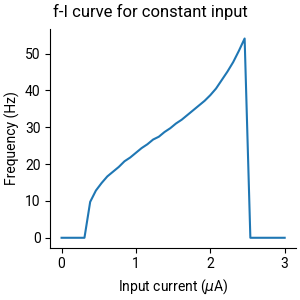

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(cur_in, fi_curve)
fig.suptitle("f-I curve for constant input")
ax.set_xlabel("Input current ($\\mu$A)")
ax.set_ylabel("Frequency (Hz)")

We now turn to noisy input currents.

Text(0.5, 0.92, 'Dynamics trajectory')

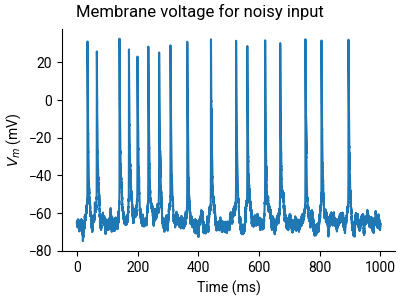

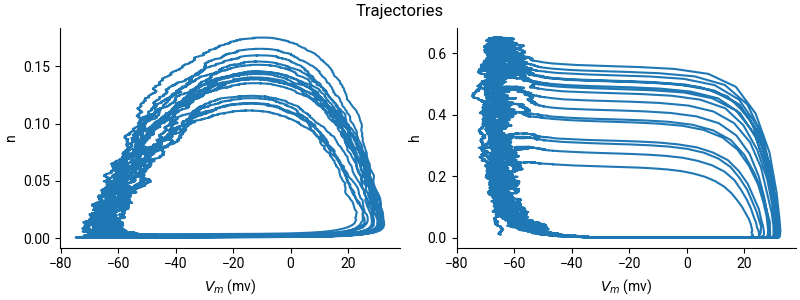

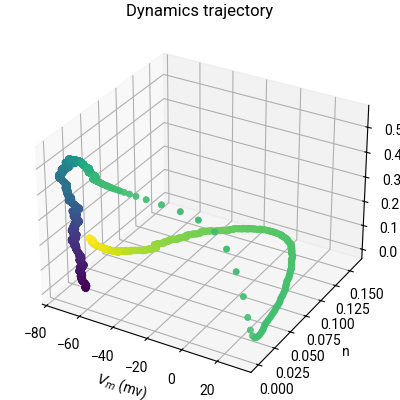

In [24]:
# Initialization of the numpy random number generator
rng = np.random.default_rng(seed=42)

ampli_ex = 200
t_max = 1000.0
t_range = np.arange(0, t_max, delta_t)
cur_in_noise = np.sqrt(delta_t) * rng.normal(scale=ampli_ex, size=t_range.size)
v_ex = np.zeros_like(cur_in_noise)
h_ex = np.zeros_like(cur_in_noise)
n_ex = np.zeros_like(cur_in_noise)
vout = -65
nout = 0.01
hout = 0.01
for i_cin, cin in enumerate(cur_in_noise):
    dvout, dnout, dhout = _step_hodgkin(vout, nout, hout, cin)
    vout += delta_t * dvout
    nout += delta_t * dnout
    hout += delta_t * dhout
    v_ex[i_cin] = vout
    h_ex[i_cin] = hout
    n_ex[i_cin] = nout
fig, ax = plt.subplots(figsize=(4, 3))
fig.suptitle("Membrane voltage for noisy input")
ax.plot(t_range, v_ex)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("$V_m$ (mV)")

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle("Trajectories")
ax[0].plot(v_ex, n_ex)
ax[0].set_xlabel("$V_m$ (mv)")
ax[0].set_ylabel("n")
ax[1].plot(v_ex, h_ex)
ax[1].set_xlabel("$V_m$ (mv)")
ax[1].set_ylabel("h")

# 3D trajectories
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection="3d")

n_pts = 5000
dyna = np.vstack([v_ex, n_ex, h_ex])[:, :n_pts]
ax.scatter(*dyna, lw=0.5, c=t_range[:n_pts])
ax.set_xlabel("$V_m$ (mv)")
ax.set_ylabel("n")
ax.set_zlabel("h")
ax.set_title("Dynamics trajectory")

In [12]:
t_max = 4000.0
t_range = np.arange(0, t_max, delta_t)

noise_ampli = np.linspace(0, 8000, 50)
fi_curve_noise = np.zeros_like(noise_ampli)
for i_noise, noise in enumerate(noise_ampli):
    cur_in_noise = np.sqrt(delta_t) * rng.normal(scale=noise, size=t_range.size)

    n_spike = 0
    vout = -65
    nout = 0.01
    hout = 0.01
    for cin in cur_in_noise:
        dvout, dnout, dhout = _step_hodgkin(vout, nout, hout, cin)
        vout_prev = vout
        vout += delta_t * dvout
        nout += delta_t * dnout
        hout += delta_t * dhout
        if ti > t_trans and vout_prev < v_thr and vout >= v_thr:
            n_spike += 1

    fi_curve_noise[i_noise] = n_spike / (t_max - t_trans) * 1000

Text(0, 0.5, 'Frequency (Hz)')

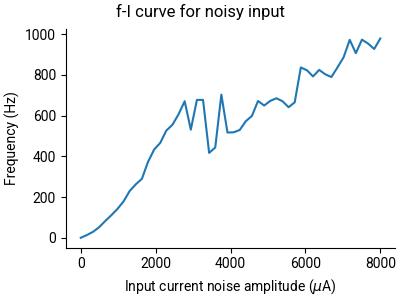

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(noise_ampli, fi_curve_noise)
fig.suptitle("f-I curve for noisy input")
ax.set_xlabel("Input current noise amplitude ($\\mu$A)")
ax.set_ylabel("Frequency (Hz)")

## Leaky Integrate and Fire (LIF) model

We now compute the same curves for the LIF model.

It is simpler but does not present all the characteristics of the HH model.

Text(0, 0.5, '$V_m$ (mV)')

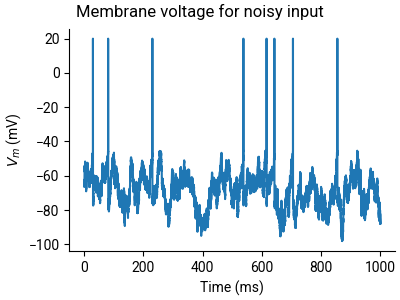

In [14]:
def _step_lif(v_in: float, cur_in: float) -> float:
    tau_lif = 20.0
    v_eq = -65.0
    c_m = 1.0
    return -1 / tau_lif * (v_in - v_eq) + cur_in / c_m


t_max = 1000.0
t_range = np.arange(0, t_max, delta_t)

v_thr = -45.0
v_r = -75.0

ampli_ex = 350
cur_in_noise = np.sqrt(delta_t) * rng.normal(scale=ampli_ex, size=t_range.size)
v_ex = np.zeros_like(cur_in_noise)
vout = -65
for i_cin, cin in enumerate(cur_in_noise):
    dvout = _step_lif(vout, cin)
    vout += delta_t * dvout
    if vout > v_thr:
        v_ex[i_cin] = 20.0
        vout = v_r
    else:
        v_ex[i_cin] = vout

fig, ax = plt.subplots(figsize=(4, 3))
fig.suptitle("Membrane voltage for noisy input")
ax.plot(t_range, v_ex)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("$V_m$ (mV)")

In [15]:
t_max = 4000.0
t_range = np.arange(0, t_max, delta_t)

noise_ampli = np.linspace(0, 10000, 50)
fi_curve_noise = np.zeros_like(noise_ampli)
for i_noise, noise in enumerate(noise_ampli):
    cur_in_noise = np.sqrt(delta_t) * rng.normal(scale=noise, size=t_range.size)

    n_spike = 0
    Vout = -65
    for cin in cur_in_noise:
        dvout = _step_lif(vout, cin)
        vout += delta_t * dvout
        if vout > v_thr:
            vout = v_r
            n_spike += 1

    fi_curve_noise[i_noise] = n_spike / (t_max - t_trans) * 1000

Text(0, 0.5, 'Frequency (Hz)')

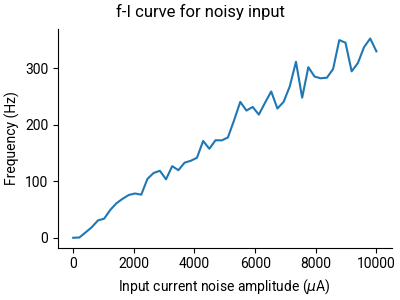

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(noise_ampli, fi_curve_noise)
fig.suptitle("f-I curve for noisy input")
ax.set_xlabel("Input current noise amplitude ($\\mu$A)")
ax.set_ylabel("Frequency (Hz)")